<a href="https://colab.research.google.com/github/Achuna/Climate-Data-UMBC-Summer-Research/blob/master/Notebooks/Time_Lag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this section, I use the concept of time lag to identify the effect a variable has on a set of data

**Articles:**

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.107.2398&rep=rep1&type=pdf

https://v2.luminpdf.com/viewer/5d1d030fb49bed00199ae3c8

# Data Preperation

In [0]:
import pandas as pd
import dask.dataframe as dd #for parallel processing
import numpy as np
from google.colab import files
import glob

#Takes in a 1D array and makes subsets of the array, returning a matrix
#Chunk size - how big each subset of the array will be
#numFiles - defines the columns
def getMatrix(array, chunkSize, numFiles):
  low = 0
  matrix = []
  for i in range(0, numFiles):
    matrix.append(array[low:low+chunkSize])
    low = low + chunkSize
  return np.transpose(matrix)


files.upload() #Upload Files from local directory

filelist = glob.glob('eof_ts_sst*') #get all files starting with eof

#reading in files
df = dd.read_csv(filelist, names=["Initial"]) #use parallel processing to read in all the files (much faster)
df = df.compute() #create dataframe

#Dask reads in all the data into a 2D array, storing all the values in their own 1D arrays. Ex. [ [21], [23], [59] ....]
#Here I am extracting the data and putting it all in a 1D array
temp = df.values
array = []
for i in range(0, len(temp)):
  array.append(temp[i][0])
  
#set the column names  
columnNames = [filename[filename.rfind('_')+1 : len(filename)] for filename in filelist]

#To reconstruct he matrix in our desired way, call the getMatrix function  
matrix = getMatrix(array, 480, len(filelist)) #480 because we are looking at 480 months ~40 yrs

df = pd.DataFrame(matrix, columns = columnNames) #assign matrix to the dataframe

df #print dataframe

,sst-14,sst-23,sst-13
0,-1.176628,1.089472,0.109273
1,-1.887745,0.610319,-0.264073
2,-1.452969,0.855055,-0.287171
3,-1.353054,0.363691,-0.656911
4,-1.245674,-0.316216,-0.746113
5,-1.025709,0.475174,-0.522640
6,-0.713539,-0.692462,-0.437077
7,-0.307972,-0.534652,-0.233569
8,-0.316837,-0.696437,-0.123470
9,0.010207,0.181521,0.293815


# Time lag


In [0]:
#Renames new lagged column
def renameColumn(column, appendString):
  return column +"_"+ appendString

#take column and shift it downwards with lag = n, creating a new column
def timeLag(dataframe, variables = [], maxLag = 4, loopBack = True, replaceNaN = None): #lag in months*
  
  data = dataframe.copy() #make a copy of dataframe
  for variable in variables:
    
    columnData = pd.DataFrame(dataframe[variable]) #look at the column we want to shift

    if(loopBack):
      for i in range(1, maxLag+1):
        tempLag = np.roll(columnData , i) #cycling dataframe

        newCol = pd.DataFrame(tempLag)
        newName = renameColumn(variable, str(i))
        data[newName] = newCol
        
    else:
      for i in range(1, maxLag+1):
        tempLag = columnData.shift(i)

        newCol = pd.DataFrame(tempLag)

        #optional: replace NaN values with your own value
        if(replaceNaN is not None):
          newCol = newCol.fillna(value=replaceNaN)

        newName = renameColumn(variable, str(i))
        data[newName] = newCol
  return data

,sst-23,sst-13,sst-14,sst-14_0,sst-14_1,sst-14_2,sst-14_3,sst-14_4,sst-14_5,sst-14_6,sst-14_7,sst-14_8,sst-14_9,sst-14_10,sst-14_11,sst-14_12,sst-14_13,sst-14_14,sst-14_15,sst-14_16,sst-14_17,sst-14_18,sst-14_19,sst-14_20,sst-14_21,sst-14_22,sst-14_23,sst-14_24,sst-14_25,sst-14_26,sst-14_27,sst-14_28,sst-14_29,sst-14_30,sst-14_31,sst-14_32,sst-14_33,sst-14_34,sst-14_35,sst-14_36,...,sst-13_440,sst-13_441,sst-13_442,sst-13_443,sst-13_444,sst-13_445,sst-13_446,sst-13_447,sst-13_448,sst-13_449,sst-13_450,sst-13_451,sst-13_452,sst-13_453,sst-13_454,sst-13_455,sst-13_456,sst-13_457,sst-13_458,sst-13_459,sst-13_460,sst-13_461,sst-13_462,sst-13_463,sst-13_464,sst-13_465,sst-13_466,sst-13_467,sst-13_468,sst-13_469,sst-13_470,sst-13_471,sst-13_472,sst-13_473,sst-13_474,sst-13_475,sst-13_476,sst-13_477,sst-13_478,sst-13_479
0,1.089472,0.109273,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.610319,-0.264073,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.855055,-0.287171,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.363691,-0.656911,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.316216,-0.746113,-1.245674,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.475174,-0.522640,-1.025709,-1.245674,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.692462,-0.437077,-0.713539,-1.025709,-1.245674,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.534652,-0.233569,-0.307972,-0.713539,-1.025709,-1.245674,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.696437,-0.123470,-0.316837,-0.307972,-0.713539,-1.025709,-1.245674,-1.353054,-1.452969,-1.887745,-1.176628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Bayesian Network (Ignore)

In [0]:
!pip install pgmpy
!pip install graphviz

In [0]:
def createBins(low, high, nbins=5, giveValue = 0.1):
  bins = []
  step = 0
  #Defining the step value (subset ranges length)
  if(low < 0):
    step = abs(low) / nbins + high / nbins
  else:
    step = high / nbins
  #Loop through N bins and create the ranges
  for i in range(0, nbins):
    bins.append([low, low+step])
    low = low+step
  #give lowest and highest bin values some give to avoid NaN of float numbers  
  bins[0][0] -= giveValue
  bins[len(bins)-1][1] += giveValue
  return bins

#given bins, this will assign the value to the index of the bin it belongs in
def assignBin(bins, value):
  for i in range(0, len(bins)):
    low = bins[i][0]
    high = bins[i][1]
    if(value >= low and value <= high):
      return i

#returns a dataframe as well as the bin information for decomposition purposes
def convertToBins(dataframe, amountOfBins, columnSet = ''):
  data = dataframe
  columns = list(data) 
  binInfo = []
  if(not columnSet):
    for i in columns: 
      maximum = data[i].max()
      minimum = data[i].min()
      bins = createBins(minimum, maximum, amountOfBins) #Creating an array of bins for column
      binInfo.append((i, bins))
      for j in range(0, len(data[i])): 
        data[i][j] = int(assignBin(bins, data[i][j])) #assigning new bin based on value of data 
  else:
    maximum = data[columnSet].max()
    minimum = data[columnSet].min()
    bins = createBins(minimum, maximum, amountOfBins) #Creating an array of bins for column
    binInfo.append((columnSet, bins))
    for j in range(0, len(data[columnSet])): 
      data[columnSet][j] = int(assignBin(bins, data[columnSet][j])) #assigning new bin based on value of data 
  return (data, binInfo)


binData = convertToBins(df, 5)

binData[0]

,sst-23,sst-13,sst-14
0,3.0,2.0,1.0
1,3.0,2.0,0.0
2,3.0,2.0,0.0
3,2.0,1.0,0.0
4,2.0,1.0,1.0
5,2.0,1.0,1.0
6,1.0,2.0,1.0
7,1.0,2.0,1.0
8,1.0,2.0,1.0
9,2.0,2.0,2.0


In [0]:
data = timeLag(binData[0], ['sst-14'], 10, -1)
data

,sst-23,sst-13,sst-14,sst-14_0,sst-14_1,sst-14_2,sst-14_3
0,3.0,2.0,1.0,-1.0,-1.0,-1.0,-1.0
1,3.0,2.0,0.0,-1.0,-1.0,-1.0,-1.0
2,3.0,2.0,0.0,-1.0,-1.0,-1.0,-1.0
3,2.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
4,2.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
5,2.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
6,1.0,2.0,1.0,-1.0,-1.0,-1.0,-1.0
7,1.0,2.0,1.0,-1.0,-1.0,-1.0,-1.0
8,1.0,2.0,1.0,-1.0,-1.0,-1.0,-1.0
9,2.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0


[('sst-13', 'sst-23'), ('sst-13', 'sst-14_1'), ('sst-13', 'sst-14'), ('sst-13', 'sst-14_0'), ('sst-14', 'sst-14_2'), ('sst-14_0', 'sst-14_1'), ('sst-14_1', 'sst-14_2'), ('sst-14_1', 'sst-14'), ('sst-14_2', 'sst-23')]


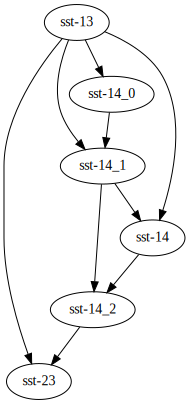

In [0]:
import pandas as pd
import numpy as np 
from pgmpy.estimators import BdeuScore, K2Score, BicScore, BayesianEstimator
from pgmpy.estimators import ConstraintBasedEstimator, HillClimbSearch #import scoring functions
from pgmpy.models import BayesianModel
from graphviz import Digraph

bdeu = BdeuScore(data, equivalent_sample_size=50)
#single edge manipulations to increase score
hc = HillClimbSearch(data, scoring_method=bdeu) 

best_model = hc.estimate()
print(best_model.edges())


#Estimate CPDs for each node
best_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") 

edges = best_model.edges()
g = Digraph('Climate', filename='Climate_Model') #name, filename
#Create connections given the edges 

for i in range(0, len(edges)):
  parent = edges[i][0]
  child = edges[i][1]
  g.edge(parent, child)
# print(g)
# print(g.view())
g
  